### Importations

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [33]:
import tensorflow.keras as keras

In [55]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score,RocCurveDisplay,roc_curve, roc_auc_score

In [4]:
import matplotlib.pyplot as plt

In [7]:
import tqdm.notebook as tqdm

In [8]:
from aizynthfinder.utils.models import LocalKerasModel

In [13]:
import SelectionGroup

### Récupération des données

In [14]:
fname_fp_false = "Fingerprint des données de validation pour les fausses réaction"
fname_fp_true = "Fingerprint des données de validation pour les vraies réaction"

In [15]:
data_fp_false = pd.read_csv(fname_fp_false)
data_fp_true = pd.read_csv(fname_fp_true)

In [17]:
def get_data(data_fp_false,data_fp_true,grps):
    '''
    Fonction pour récupérer la data
    '''
    res = []
    fp_grps = SelectionGroup.select_grp(data_fp_false,data_fp_true,grps)
    for prod_fp_false,rxn_fp_false,prod_fp_true,rxn_fp_true in fp_grps:
        prod_fp,rxn_fp = np.concatenate((prod_fp_false,prod_fp_true)),np.concatenate((rxn_fp_false,rxn_fp_true))
        labels = np.array([0]*prod_fp_false.shape[0]+[1]*prod_fp_true.shape[0])
        train_prop = 0.9
        test_prop  = 0.1
        assert(test_prop+train_prop==1)
        res.append(train_test_split(prod_fp, rxn_fp, labels, train_size = train_prop, random_state=42))
    return res

In [18]:
data = get_data(data_fp_false, data_fp_true, ['Alcool'])

### Récupération des modèles

In [40]:
def load_ai_model():
    return LocalKerasModel("C:/Users/Yassine/Desktop/aizynth/uspto_filter_model.hdf5").model

In [35]:
def load_our_model(grp):
    return keras.models.load_model(f"transfer/our_model_{grp}")

### Evaluation des modèles

In [22]:
def plot_roc_curve_from_res(fpr,tpr,thresholds):
    plt.xlabel("taux de faux positifs")
    plt.ylabel("taux de vrais positifs")


In [21]:
def evaluate_model(l_model, data, num_folds=10,  loss_function="binary_crossentropy", 
                   optimizer="adam", metrics=['accuracy'], nb_epochs=10):
    
    '''
    Fonction qui évalue un modèle par k-fold : création du modèle, entraînement, training, testing et résultats
    '''
    
    # Merge inputs and targets
    inputs1_train, inputs1_test, inputs2_train, inputs2_test, label_train, label_test = data[0]
    
    p_bar = tqdm.tqdm(total=num_folds)
    
    #Création d'un k-fold
    kfold = KFold(n_splits=num_folds, shuffle=True)
    inputs1 = np.concatenate((inputs1_train, inputs1_test), axis=0)
    inputs2 = np.concatenate((inputs2_train, inputs2_test), axis=0)
    targets = np.concatenate((label_train, label_test), axis=0)
    
    
    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []
    
    
    for train, test in kfold.split(inputs1, inputs2, targets):
        model = l_model()
        model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        # Fit data to model
        history = model.fit([inputs1[train], inputs2[train]], targets[train],
                      epochs=nb_epochs,
                      verbose=2)

        # Generate generalization metrics
        scores = model.evaluate([inputs1[test],inputs2[test]], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        
        labels_pred = model.predict([inputs1[test],inputs2[test]])
        labels_true = targets[test]
        labels_pred_bin = [x > 0.5 for x in labels_pred]
        
        precision, recall, fscore, support = score(labels_true, labels_pred_bin, pos_label=1, average='binary')
        print(score(labels_true, labels_pred_bin, pos_label=1, average='binary'))
        fpr, tpr, thresholds = roc_curve(labels_true, labels_pred)
        plot_roc_curve_from_res(fpr,tpr,thresholds)
        
        # Increase fold number
        fold_no = fold_no + 1
        p_bar.update(1)
    return acc_per_fold, loss_per_fold
  

In [59]:
def evaluate_model_ai_compare(l_model, data, grp='Alcool', num_folds=10,  loss_function="binary_crossentropy", 
                   optimizer="adam", metrics=['accuracy'], nb_epochs=10):
    
    '''
    Fonction qui compare notre modèle avec 
    '''
    
    # Merge inputs and targets
    inputs1_train, inputs1_test, inputs2_train, inputs2_test, label_train, label_test = data[0]
    p_bar = tqdm.tqdm(total=num_folds)
    
    kfold = KFold(n_splits=num_folds, shuffle=True)
    inputs1 = np.concatenate((inputs1_train, inputs1_test), axis=0)
    inputs2 = np.concatenate((inputs2_train, inputs2_test), axis=0)
    targets = np.concatenate((label_train, label_test), axis=0)
    
    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []
    
    for train, test in kfold.split(inputs1, inputs2, targets):
        model = l_model(grp)
        ai_model = load_ai_model()
        model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
        ai_model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        
        # Fit data to model
        history = model.fit([inputs1[train], inputs2[train]], targets[train],
                      epochs=nb_epochs,
                      verbose=2)
        history2 = ai_model.fit([inputs1[train], inputs2[train]], targets[train],
                      epochs=nb_epochs,
                      verbose=2)

        # Generate generalization metrics
        print('------------------------------------------------------------------------')
        print(f'Evaluating for fold {fold_no} ...')
        scores = model.evaluate([inputs1[test],inputs2[test]], targets[test], verbose=0)
        ai_scores = ai_model.evaluate([inputs1[test],inputs2[test]], targets[test], verbose=0)
        
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        print(f'AiZynthFinder Score for fold {fold_no}: {model.metrics_names[0]} of {ai_scores[0]}; {model.metrics_names[1]} of {ai_scores[1]*100}%')
        
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        
        print('------------------------------------------------------------------------')
        print(f'Prediciting for fold {fold_no} ...')
        
        labels_pred = model.predict([inputs1[test],inputs2[test]])
        ai_labels_pred = ai_model.predict([inputs1[test], inputs2[test]])
        labels_true = targets[test]
        labels_pred_bin = [x > 0.05 for x in labels_pred]
        ai_labels_pred_bin = [x > 0.05 for x in ai_labels_pred]
        
        print('-------------------------------------------------------------------------')
        print('Results')
        
        precision, recall, fscore, support = score(labels_true, labels_pred_bin, pos_label=1, average='binary')
        
        print(score(labels_true, labels_pred_bin, pos_label=1, average='binary'))
        print(score(labels_true, ai_labels_pred_bin, pos_label=1, average='binary'))
        
        fpr, tpr, thresholds = roc_curve(labels_true, labels_pred)
        ai_fpr, ai_tpr, ai_thresholds = roc_curve(labels_true, ai_labels_pred)
        
        auc = roc_auc_score(labels_true, labels_pred)
        ai_auc = roc_auc_score(labels_true, ai_labels_pred)
        
        #On plot les courbes ROC
        plt.plot(fpr, fpr, color = 'green', linestyle='--', label = "Random")
        plt.plot(fpr,tpr, color = 'orange', label = f'TL({grp}) : AUC = {np.round(auc,3)}')
        plt.plot(ai_fpr, ai_tpr, color = 'blue', label = f'AZF : AUC = {np.round(ai_auc,3)}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='best')
        plt.savefig(f'graph_ai_compare_{fold_no}.png')
        plt.show()
        
        # Increase fold number
        fold_no = fold_no + 1
        p_bar.update(1)
    return acc_per_fold, loss_per_fold
  

  0%|          | 0/2 [00:01<?, ?it/s]

[269163, 269163, 269163]
[269163, 269163, 269163]
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/3
4206/4206 - 49s - loss: 0.2752 - accuracy: 0.9180 - 49s/epoch - 12ms/step
Epoch 2/3
4206/4206 - 43s - loss: 0.1090 - accuracy: 0.9659 - 43s/epoch - 10ms/step
Epoch 3/3
4206/4206 - 45s - loss: 0.0744 - accuracy: 0.9782 - 45s/epoch - 11ms/step
Score for fold 1: loss of 0.22735586762428284; accuracy of 94.90496516227722%
[134582, 134582]
[134582, 134582]
[134582, 134582]
[134582, 134582]
[134582, 134582]
[134582, 134582]
(0.9586746385018569, 0.9806904727690761, 0.9695575928433484, None)
[134582, 134582]


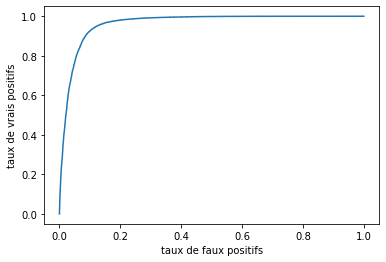

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/3
4206/4206 - 43s - loss: 0.2726 - accuracy: 0.9198 - 43s/epoch - 10ms/step
Epoch 2/3
4206/4206 - 43s - loss: 0.1051 - accuracy: 0.9671 - 43s/epoch - 10ms/step
Epoch 3/3
4206/4206 - 43s - loss: 0.0706 - accuracy: 0.9797 - 43s/epoch - 10ms/step
Score for fold 2: loss of 0.24955704808235168; accuracy of 94.72064971923828%
[134581, 134581]
[134581, 134581]
[134581, 134581]
[134581, 134581]
[134581, 134581]
[134581, 134581]
(0.9530123628765453, 0.9846362810445171, 0.9685662586105446, None)
[134581, 134581]


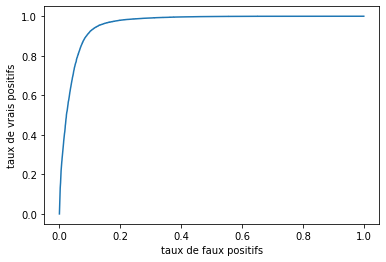

([94.90496516227722, 94.72064971923828],
 [0.22735586762428284, 0.24955704808235168])

In [24]:
evaluate_model(create_model, test, num_folds=2, nb_epochs=3)

  0%|          | 0/5 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/6
6730/6730 - 82s - loss: 0.4425 - accuracy: 0.9034 - 82s/epoch - 12ms/step
Epoch 2/6
6730/6730 - 80s - loss: 0.1747 - accuracy: 0.9419 - 80s/epoch - 12ms/step
Epoch 3/6
6730/6730 - 79s - loss: 0.1420 - accuracy: 0.9544 - 79s/epoch - 12ms/step
Epoch 4/6
6730/6730 - 80s - loss: 0.1235 - accuracy: 0.9614 - 80s/epoch - 12ms/step
Epoch 5/6
6730/6730 - 80s - loss: 0.1079 - accuracy: 0.9664 - 80s/epoch - 12ms/step
Epoch 6/6
6730/6730 - 80s - loss: 0.1017 - accuracy: 0.9695 - 80s/epoch - 12ms/step
------------------------------------------------------------------------
Evaluating for fold 1 ...
Score for fold 1: loss of 0.18292132019996643; accuracy of 95.04950642585754%
AiZynthFinder Score for fold 1: loss of 1.7554512023925781; accuracy of 68.43757629394531%
------------------------------------------------------------------------
Prediciting for fold 1 ...
-------------------------------

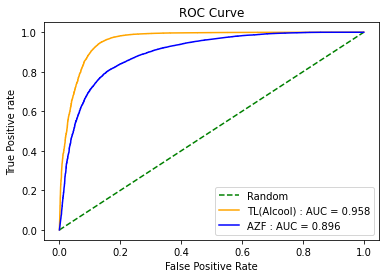

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/6
6730/6730 - 80s - loss: 0.4430 - accuracy: 0.9020 - 80s/epoch - 12ms/step
Epoch 2/6
6730/6730 - 78s - loss: 0.1741 - accuracy: 0.9422 - 78s/epoch - 12ms/step
Epoch 3/6
6730/6730 - 79s - loss: 0.1443 - accuracy: 0.9541 - 79s/epoch - 12ms/step
Epoch 4/6
6730/6730 - 79s - loss: 0.1218 - accuracy: 0.9616 - 79s/epoch - 12ms/step
Epoch 5/6
6730/6730 - 77s - loss: 0.1084 - accuracy: 0.9664 - 77s/epoch - 12ms/step
Epoch 6/6
6730/6730 - 78s - loss: 0.0986 - accuracy: 0.9694 - 78s/epoch - 12ms/step
------------------------------------------------------------------------
Evaluating for fold 2 ...
Score for fold 2: loss of 0.1853647083044052; accuracy of 94.89718079566956%
AiZynthFinder Score for fold 2: loss of 1.7645355463027954; accuracy of 68.29825639724731%
------------------------------------------------------------------------
Prediciting for fold 2 ...
--------------------------------

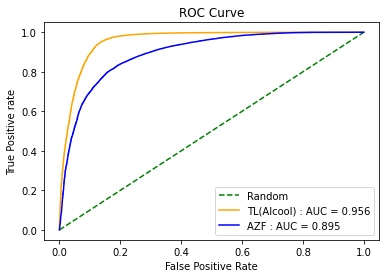

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/6
6730/6730 - 82s - loss: 0.4287 - accuracy: 0.9035 - 82s/epoch - 12ms/step
Epoch 2/6
6730/6730 - 79s - loss: 0.1746 - accuracy: 0.9418 - 79s/epoch - 12ms/step
Epoch 3/6
6730/6730 - 80s - loss: 0.1428 - accuracy: 0.9537 - 80s/epoch - 12ms/step
Epoch 4/6
6730/6730 - 78s - loss: 0.1238 - accuracy: 0.9609 - 78s/epoch - 12ms/step
Epoch 5/6
6730/6730 - 79s - loss: 0.1093 - accuracy: 0.9662 - 79s/epoch - 12ms/step
Epoch 6/6
6730/6730 - 79s - loss: 0.1025 - accuracy: 0.9693 - 79s/epoch - 12ms/step
------------------------------------------------------------------------
Evaluating for fold 3 ...
Score for fold 3: loss of 0.1895321160554886; accuracy of 94.96033787727356%
AiZynthFinder Score for fold 3: loss of 1.7558871507644653; accuracy of 68.32240223884583%
------------------------------------------------------------------------
Prediciting for fold 3 ...
--------------------------------

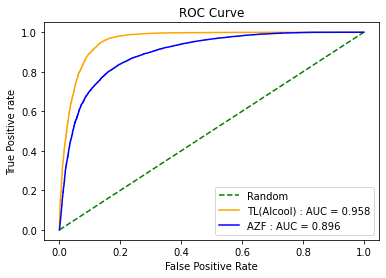

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/6
6730/6730 - 81s - loss: 0.4296 - accuracy: 0.9032 - 81s/epoch - 12ms/step
Epoch 2/6
6730/6730 - 82s - loss: 0.1729 - accuracy: 0.9424 - 82s/epoch - 12ms/step
Epoch 3/6
6730/6730 - 81s - loss: 0.1433 - accuracy: 0.9541 - 81s/epoch - 12ms/step
Epoch 4/6
6730/6730 - 81s - loss: 0.1215 - accuracy: 0.9613 - 81s/epoch - 12ms/step
Epoch 5/6
6730/6730 - 85s - loss: 0.1102 - accuracy: 0.9659 - 85s/epoch - 13ms/step
Epoch 6/6
6730/6730 - 82s - loss: 0.1030 - accuracy: 0.9695 - 82s/epoch - 12ms/step
------------------------------------------------------------------------
Evaluating for fold 4 ...
Score for fold 4: loss of 0.1777389794588089; accuracy of 95.0717031955719%
AiZynthFinder Score for fold 4: loss of 1.7631701231002808; accuracy of 68.08218359947205%
------------------------------------------------------------------------
Prediciting for fold 4 ...
---------------------------------

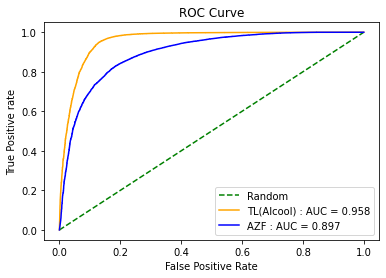

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/6
6730/6730 - 81s - loss: 0.4371 - accuracy: 0.9040 - 81s/epoch - 12ms/step
Epoch 2/6
6730/6730 - 79s - loss: 0.1745 - accuracy: 0.9424 - 79s/epoch - 12ms/step
Epoch 3/6
6730/6730 - 79s - loss: 0.1429 - accuracy: 0.9538 - 79s/epoch - 12ms/step
Epoch 4/6
6730/6730 - 79s - loss: 0.1226 - accuracy: 0.9611 - 79s/epoch - 12ms/step
Epoch 5/6
6730/6730 - 80s - loss: 0.1104 - accuracy: 0.9664 - 80s/epoch - 12ms/step
Epoch 6/6
6730/6730 - 79s - loss: 0.1020 - accuracy: 0.9693 - 79s/epoch - 12ms/step
------------------------------------------------------------------------
Evaluating for fold 5 ...
Score for fold 5: loss of 0.1818135678768158; accuracy of 95.10700106620789%
AiZynthFinder Score for fold 5: loss of 1.758557915687561; accuracy of 68.38311553001404%
------------------------------------------------------------------------
Prediciting for fold 5 ...
---------------------------------

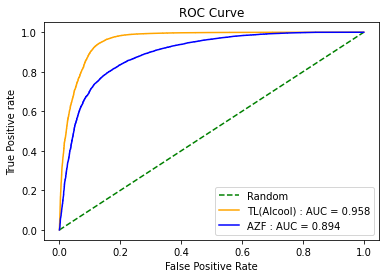

([95.04950642585754,
  94.89718079566956,
  94.96033787727356,
  95.0717031955719,
  95.10700106620789],
 [0.18292132019996643,
  0.1853647083044052,
  0.1895321160554886,
  0.1777389794588089,
  0.1818135678768158])

In [60]:
evaluate_model_ai_compare(load_our_model, data, num_folds=5, nb_epochs=6, )